# Telecom churn case study

## Objective
We need to analyse telecom industry data and predict high value customers who are at high risk of churn and identify main indicators of churn

## Contents###

1. Data understanding and cleaning
2. Exploratory data analysis (EDA)
3. Model building
   * a. PCA with LR
   * b. Decision tree 
   * c. Random forest 
   * d. Logistic regression 
4. Inferences
5. Recommendation

## 1. Data understanding and cleaning

###  Import and load the file

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
    
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# Load csv data file
telecom_orig = pd.read_csv('telecom_churn_data.csv', low_memory=False)

In [3]:
# Understand the properties of loaded dataframe
telecom = telecom_orig.copy()
print('Dataframe Shape: ', telecom.shape);
print("Dataframe Info: \n"); telecom.info();
telecom.head(5)

Dataframe Shape:  (99999, 226)
Dataframe Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,...,0,1.00,1.00,1.00,nan,968,30.40,0.00,101.20,3.58
1,7001865778,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.05,...,0,nan,1.00,1.00,nan,1006,0.00,0.00,0.00,0.00
2,7001625959,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.69,...,0,nan,nan,nan,1.00,1103,0.00,0.00,4.17,0.00
3,7001204172,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.34,...,0,nan,nan,nan,nan,2491,0.00,0.00,0.00,0.00
4,7000142493,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.64,...,0,0.00,nan,nan,nan,1526,0.00,0.00,0.00,0.00


### Treating Categorical Variables
There are 8 of them and all of these have more than 74% missing values.
Missing values can be imputed with '-1' where -1 can be treated as a new category.

CATEGORICAL VARIABLES:
* night_pck_user_6
* night_pck_user_7
* night_pck_user_8
* night_pck_user_9
* fb_user_6
* fb_user_7
* fb_user_8
* fb_user_9

In [4]:
# Missing values can be imputed with '-1' 
# where -1 can be treated as a new category.

categorical_vars = ["night_pck_user_6", "night_pck_user_7", "night_pck_user_8", 
"night_pck_user_9", "fb_user_6", "fb_user_7", "fb_user_8", "fb_user_9"]

for var in categorical_vars:
    telecom[var].fillna(value=-1, inplace=True)

In [5]:
# Create dummy variables for all the six categorial variables
night_pck_user_6_s = pd.get_dummies(telecom['night_pck_user_6'],prefix="night6",drop_first=True)
night_pck_user_7_s = pd.get_dummies(telecom['night_pck_user_7'],prefix="night7",drop_first=True)
night_pck_user_8_s = pd.get_dummies(telecom['night_pck_user_8'],prefix="night8",drop_first=True)

fb_user_6_s = pd.get_dummies(telecom['fb_user_6'],prefix="fb6", drop_first=True)
fb_user_7_s = pd.get_dummies(telecom['fb_user_7'],prefix="fb7",drop_first=True)
fb_user_8_s = pd.get_dummies(telecom['fb_user_8'],prefix="fb8",drop_first=True)

telecom = pd.concat([telecom,night_pck_user_6_s],axis=1)
telecom = pd.concat([telecom,night_pck_user_7_s],axis=1)
telecom = pd.concat([telecom,night_pck_user_8_s],axis=1)

telecom = pd.concat([telecom,fb_user_6_s],axis=1)
telecom = pd.concat([telecom,fb_user_7_s],axis=1)
telecom = pd.concat([telecom,fb_user_8_s],axis=1)

# drop all categorial columns
telecom = telecom.drop(['fb_user_6', 'fb_user_7', 'fb_user_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8'], 1)

### Missing Value Treatment

#### Column: missing values

In [6]:
# summing up the missing values (column-wise)
telecom.isnull().sum()

mobile_number              0
circle_id                  0
loc_og_t2o_mou          1018
std_og_t2o_mou          1018
loc_ic_t2o_mou          1018
last_date_of_month_6       0
last_date_of_month_7     601
last_date_of_month_8    1100
last_date_of_month_9    1659
arpu_6                     0
arpu_7                     0
arpu_8                     0
arpu_9                     0
onnet_mou_6             3937
onnet_mou_7             3859
onnet_mou_8             5378
onnet_mou_9             7745
offnet_mou_6            3937
offnet_mou_7            3859
offnet_mou_8            5378
offnet_mou_9            7745
roam_ic_mou_6           3937
roam_ic_mou_7           3859
roam_ic_mou_8           5378
roam_ic_mou_9           7745
roam_og_mou_6           3937
roam_og_mou_7           3859
roam_og_mou_8           5378
roam_og_mou_9           7745
loc_og_t2t_mou_6        3937
                        ... 
sachet_2g_6                0
sachet_2g_7                0
sachet_2g_8                0
sachet_2g_9   

In [7]:
# Percentage of missing values (column-wise)
round(100*(telecom.isnull().sum()/len(telecom.index)), 2)

mobile_number          0.00
circle_id              0.00
loc_og_t2o_mou         1.02
std_og_t2o_mou         1.02
loc_ic_t2o_mou         1.02
last_date_of_month_6   0.00
last_date_of_month_7   0.60
last_date_of_month_8   1.10
last_date_of_month_9   1.66
arpu_6                 0.00
arpu_7                 0.00
arpu_8                 0.00
arpu_9                 0.00
onnet_mou_6            3.94
onnet_mou_7            3.86
onnet_mou_8            5.38
onnet_mou_9            7.75
offnet_mou_6           3.94
offnet_mou_7           3.86
offnet_mou_8           5.38
offnet_mou_9           7.75
roam_ic_mou_6          3.94
roam_ic_mou_7          3.86
roam_ic_mou_8          5.38
roam_ic_mou_9          7.75
roam_og_mou_6          3.94
roam_og_mou_7          3.86
roam_og_mou_8          5.38
roam_og_mou_9          7.75
loc_og_t2t_mou_6       3.94
                       ... 
sachet_2g_6            0.00
sachet_2g_7            0.00
sachet_2g_8            0.00
sachet_2g_9            0.00
monthly_3g_6        

In [8]:
# Columns with more than 70% missing values
colmns_missing_data = round(100*(telecom.isnull().sum()/len(telecom.index)), 2)
colmns_missing_data[colmns_missing_data >= 70]

date_of_last_rech_data_6   74.85
date_of_last_rech_data_7   74.43
date_of_last_rech_data_8   73.66
date_of_last_rech_data_9   74.08
total_rech_data_6          74.85
total_rech_data_7          74.43
total_rech_data_8          73.66
total_rech_data_9          74.08
max_rech_data_6            74.85
max_rech_data_7            74.43
max_rech_data_8            73.66
max_rech_data_9            74.08
count_rech_2g_6            74.85
count_rech_2g_7            74.43
count_rech_2g_8            73.66
count_rech_2g_9            74.08
count_rech_3g_6            74.85
count_rech_3g_7            74.43
count_rech_3g_8            73.66
count_rech_3g_9            74.08
av_rech_amt_data_6         74.85
av_rech_amt_data_7         74.43
av_rech_amt_data_8         73.66
av_rech_amt_data_9         74.08
arpu_3g_6                  74.85
arpu_3g_7                  74.43
arpu_3g_8                  73.66
arpu_3g_9                  74.08
arpu_2g_6                  74.85
arpu_2g_7                  74.43
arpu_2g_8 

In [9]:
# Treat missing values
# Columns used for filtering high-value customers, can't be dropped
# total_rech_data_6 
# total_rech_data_7 
# av_rech_amt_data_6 
# av_rech_amt_data_7 

# All these columns has more than 70% missing values

print(telecom.total_rech_data_6.describe());
print(telecom.total_rech_data_7.describe()); 
print(telecom.av_rech_amt_data_6.describe()); 
print(telecom.av_rech_amt_data_7.describe());

count   25153.00
mean        2.46
std         2.79
min         1.00
25%         1.00
50%         1.00
75%         3.00
max        61.00
Name: total_rech_data_6, dtype: float64
count   25571.00
mean        2.67
std         3.03
min         1.00
25%         1.00
50%         1.00
75%         3.00
max        54.00
Name: total_rech_data_7, dtype: float64
count   25153.00
mean      192.60
std       192.65
min         1.00
25%        82.00
50%       154.00
75%       252.00
max      7546.00
Name: av_rech_amt_data_6, dtype: float64
count   25571.00
mean      200.98
std       196.79
min         0.50
25%        92.00
50%       154.00
75%       252.00
max      4365.00
Name: av_rech_amt_data_7, dtype: float64


(array([1.4539e+04, 8.0550e+03, 1.8810e+03, 4.6500e+02, 3.0400e+02,
        1.4100e+02, 4.4000e+01, 4.4000e+01, 3.8000e+01, 1.3000e+01,
        1.3000e+01, 1.0000e+01, 7.0000e+00, 6.0000e+00, 4.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([5.00000e-01, 1.75080e+02, 3.49660e+02, 5.24240e+02, 6.98820e+02,
        8.73400e+02, 1.04798e+03, 1.22256e+03, 1.39714e+03, 1.57172e+03,
        1.74630e+03, 1.92088e+03, 2.09546e+03, 2.27004e+03, 2.44462e+03,
        2.61920e+03, 2.79378e+03, 2.96836e+03, 3.14294e+03, 3.31752e+03,
        3.49210e+03, 3.66668e+03, 3.84126e+03, 4.01584e+03, 4.19042e+03,
        4.36500e+03]),
 <a list of 25 Patch objects>)

<Figure size 432x288 with 0 Axes>

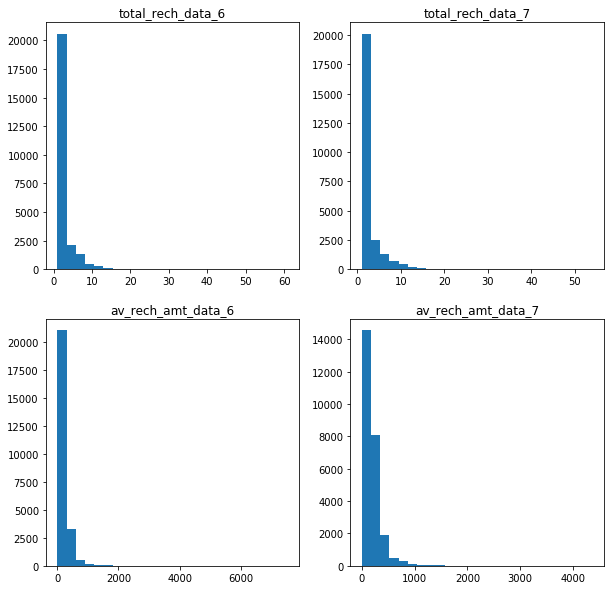

In [10]:
# Let us look at the distribution to find out the value to fill
# total_rech_data_6
plt.figure(1)
fig, ax = plt.subplots(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("total_rech_data_6")
plt.hist(telecom.total_rech_data_6.dropna(),bins=25)

# total_rech_data_7
plt.subplot(2,2,2)
plt.title("total_rech_data_7")
plt.hist(telecom.total_rech_data_7.dropna(),bins=25)

# av_rech_amt_data_6
plt.subplot(2,2,3)
plt.title("av_rech_amt_data_6")
plt.hist(telecom.av_rech_amt_data_6.dropna(),bins=25)

# total_rech_data_7
plt.subplot(2,2,4)
plt.title("av_rech_amt_data_7")
plt.hist(telecom.av_rech_amt_data_7.dropna(),bins=25)

In [11]:
# Variables are numeric and distribution resemble the 'power law'. 
# The minimum value is 1, and not zero, 
# The rows with missing values also have the 'dates of recharge' columns 
# missing -- indicating that no recharge was done in this month. 
# Thus, missing values can be imputed with 0.

telecom.total_rech_data_6.fillna(value=0, inplace=True)
telecom.total_rech_data_7.fillna(value=0, inplace=True)
telecom.total_rech_data_8.fillna(value=0, inplace=True)
telecom.total_rech_data_9.fillna(value=0, inplace=True)

telecom.av_rech_amt_data_6.fillna(value=0, inplace=True)
telecom.av_rech_amt_data_7.fillna(value=0, inplace=True)
telecom.av_rech_amt_data_8.fillna(value=0, inplace=True)
telecom.av_rech_amt_data_9.fillna(value=0, inplace=True)

In [12]:
# Column analysis % of missing values
print(round(100*(telecom.isnull().sum()/len(telecom.index)), 2)); 

# Columns with more than 70% missing values
colmns_missing_data = round(100*(telecom.isnull().sum()/len(telecom.index)), 2)
print(colmns_missing_data[colmns_missing_data >= 70])

mobile_number          0.00
circle_id              0.00
loc_og_t2o_mou         1.02
std_og_t2o_mou         1.02
loc_ic_t2o_mou         1.02
last_date_of_month_6   0.00
last_date_of_month_7   0.60
last_date_of_month_8   1.10
last_date_of_month_9   1.66
arpu_6                 0.00
arpu_7                 0.00
arpu_8                 0.00
arpu_9                 0.00
onnet_mou_6            3.94
onnet_mou_7            3.86
onnet_mou_8            5.38
onnet_mou_9            7.75
offnet_mou_6           3.94
offnet_mou_7           3.86
offnet_mou_8           5.38
offnet_mou_9           7.75
roam_ic_mou_6          3.94
roam_ic_mou_7          3.86
roam_ic_mou_8          5.38
roam_ic_mou_9          7.75
roam_og_mou_6          3.94
roam_og_mou_7          3.86
roam_og_mou_8          5.38
roam_og_mou_9          7.75
loc_og_t2t_mou_6       3.94
                       ... 
sachet_2g_6            0.00
sachet_2g_7            0.00
sachet_2g_8            0.00
sachet_2g_9            0.00
monthly_3g_6        

In [13]:
drop_missing_values_columns = colmns_missing_data[colmns_missing_data > 70].index
telecom.drop(drop_missing_values_columns, axis=1, inplace=True)

print('Number of columns droped here  = ', len(drop_missing_values_columns))
print('Dataframe Shape: ', telecom.shape)

Number of columns droped here  =  24
Dataframe Shape:  (99999, 208)


### Filter High-Value Customers

In [14]:
# New DERIVED Columns for Total Data Recharge Amount

telecom["total_rech_data_amt_6"] = telecom["total_rech_data_6"]*telecom['av_rech_amt_data_6']
telecom["total_rech_data_amt_7"] = telecom["total_rech_data_7"]*telecom['av_rech_amt_data_7']
telecom["total_rech_data_amt_8"] = telecom["total_rech_data_8"]*telecom['av_rech_amt_data_8']
telecom["total_rech_data_amt_9"] = telecom["total_rech_data_9"]*telecom['av_rech_amt_data_9']

# We can drop total_rech_data_* and av_rech_amt_data_*
drop_data_columns = ["total_rech_data_6", "total_rech_data_7", "total_rech_data_8", "total_rech_data_9", 
                'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']
telecom.drop(drop_data_columns, axis=1, inplace=True)

In [15]:
# Filter high-value customers
avg_rech_amt_6_7 = (telecom["total_rech_amt_6"] + telecom["total_rech_data_amt_6"] + 
                      telecom["total_rech_amt_7"] + telecom["total_rech_data_amt_7"]) / 2.0

avg_rch_amt_70_p = np.percentile(avg_rech_amt_6_7, 70.0)
print('70 percentile of first two months avg recharge amount: ', avg_rch_amt_70_p)

telecom = telecom[avg_rech_amt_6_7 >= avg_rch_amt_70_p]
print('Dataframe Shape: ', telecom.shape)

70 percentile of first two months avg recharge amount:  478.0
Dataframe Shape:  (30001, 204)


### Identify Curn & Tag Churners

In [16]:
# Identify Churn
X = telecom["total_ic_mou_9"] + telecom["total_og_mou_9"] + telecom["vol_2g_mb_9"] + telecom["vol_3g_mb_9"]
telecom["churn"] = np.where(X, 0, 1)

# Columns to be dropped: all columns ending with "_9"
drop_fourth_month_columns = [x for x in list(telecom) if x.endswith("_9")]
drop_fourth_month_columns += ["sep_vbc_3g"]
telecom.drop(drop_fourth_month_columns, axis=1, inplace=True)

print('Number of columns droped here  = ', len(drop_fourth_month_columns))
print('Dataframe Shape: ', telecom.shape); 

Number of columns droped here  =  48
Dataframe Shape:  (30001, 157)


### Identify columns which have no varience in values and drop them

In [17]:
# Identify columns that have no varience
telecom_unique_count = telecom.nunique().sort_values(ascending=False)

# Identify bad colums that has no infromation (all entries are NA or same)
# Find columns with all NULL entries and add to drop_columns list
telecom_unique_count_is_zero = telecom_unique_count[telecom_unique_count == 0]
print("Dataframe Unique Value Count is ZERO (all null values): \n", telecom_unique_count_is_zero); 
drop_no_varience_columns = list(telecom_unique_count_is_zero.index)

# Find columns with all same entries and add to drop_columns list
telecom_unique_count_is_one = telecom_unique_count[telecom_unique_count == 1]
print("Dataframe Unique Value Count is ONE (all same values): \n", telecom_unique_count_is_one); 
drop_no_varience_columns += list(telecom_unique_count_is_one.index)

telecom.drop(drop_no_varience_columns, axis=1, inplace=True)

print('Dataframe Shape: ', telecom.shape); 
print('Number of columns dropped here  = ', len(drop_no_varience_columns))
print('Dataframe Shape: ', telecom.shape); 

Dataframe Unique Value Count is ZERO (all null values): 
 Series([], dtype: int64)
Dataframe Unique Value Count is ONE (all same values): 
 last_date_of_month_7    1
circle_id               1
loc_og_t2o_mou          1
std_og_t2o_mou          1
loc_ic_t2o_mou          1
last_date_of_month_6    1
std_ic_t2o_mou_6        1
last_date_of_month_8    1
std_ic_t2o_mou_7        1
std_og_t2c_mou_6        1
std_og_t2c_mou_7        1
std_og_t2c_mou_8        1
std_ic_t2o_mou_8        1
dtype: int64
Dataframe Shape:  (30001, 144)
Number of columns dropped here  =  13
Dataframe Shape:  (30001, 144)


In [18]:
#Dataframe till now
telecom.head(5)

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,fb6_0.0,fb6_1.0,fb7_0.0,fb7_1.0,fb8_0.0,fb8_1.0,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,churn
0,7000842753,197.38,214.82,213.80,nan,nan,0.00,nan,nan,0.00,...,0,1,0,1,0,1,252.00,252.00,252.00,1
7,7000701601,1069.18,1349.85,3171.48,57.84,54.68,52.29,453.43,567.16,325.91,...,0,0,0,0,0,0,0.00,0.00,0.00,1
8,7001524846,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,...,0,0,0,1,0,1,0.00,354.00,207.00,0
21,7002124215,514.45,597.75,637.76,102.41,132.11,85.14,757.93,896.68,983.39,...,0,0,0,0,0,0,0.00,0.00,0.00,0
23,7000887461,74.35,193.90,366.97,48.96,50.66,33.58,85.41,89.36,205.89,...,0,0,0,1,0,1,0.00,712.00,540.00,0


#### Row: missing values

In [19]:
# sum it up to check how many rows have all missing values
print("Rows with all NULL values =",  telecom.isnull().all(axis=1).sum())

# sum of misisng values in each row
rows_missing_data = telecom.isnull().sum(axis=1)
rows_missing_data[rows_missing_data > 0]

Rows with all NULL values = 0


0        54
77       27
91        1
111      27
188      28
191       1
358      27
364      27
414      28
423      27
527      27
539      54
588       1
603       2
679       1
687      82
690      28
723      28
788      27
845      28
895      27
933      27
934      27
1138     54
1255     27
1374      1
1489     54
1500     55
1524     28
1555     56
         ..
98790    55
98823    28
98838     1
98872    28
98943    81
98962    27
98971     1
99000    27
99034    27
99070    27
99135    81
99142    81
99195    27
99224     2
99246    27
99296    27
99313     1
99323    27
99338    81
99391    27
99398    28
99436    28
99515     1
99611    27
99625    27
99672     1
99700    27
99790    55
99827    27
99851    56
Length: 1838, dtype: int64

In [20]:
# some of the rows has more than or equal to 27 missing values on an average
drop_rows = telecom.isnull().sum(axis=1) >= 27
print("Number of rows with more/equal 27 missing values = {}".format(drop_rows.sum()))
print("     % of rows with more/equal 27 missing values = {} %".format(drop_rows.sum()/telecom.shape[0]*100))

# drop rows with missing values greater >= 27
telecom = telecom[telecom.isnull().sum(axis=1) < 27]
print('Dataframe Shape after dropping rows: ', telecom.shape); 

Number of rows with more/equal 27 missing values = 1497
     % of rows with more/equal 27 missing values = 4.989833672210926 %
Dataframe Shape after dropping rows:  (28504, 144)


In [21]:
rows_missing_data = telecom.isnull().sum(axis=1)
#print(rows_missing_data)
print(rows_missing_data[rows_missing_data > 0])

91       1
191      1
588      1
603      2
679      1
1374     1
1913     1
2777     1
3757     1
4284     1
4814     1
4934     1
5187     1
5449     1
5798     1
5926     1
7304     1
7399     1
7567     1
7662     1
7914     1
8118     1
8159     1
8281     1
8454     1
8680     1
8979     1
9012     1
9027     1
9068     1
        ..
93165    1
93483    1
93755    1
93769    1
94057    1
94089    1
94241    1
94719    1
94970    1
95531    1
95638    1
95709    1
96053    1
96387    1
96403    1
96480    1
96522    1
96524    1
96715    2
97077    1
97158    1
97926    1
98753    1
98789    1
98838    1
98971    1
99224    2
99313    1
99515    1
99672    1
Length: 341, dtype: int64


In [22]:
# look at the column summary again
df = round(100*(telecom.isnull().sum()/len(telecom.index)), 2)
df[df > 0]

date_of_last_rech_6   0.12
date_of_last_rech_7   0.18
date_of_last_rech_8   0.97
dtype: float64

Note: The remaining missing values are in date columns, before imputing ned to convert them into appropriate values for analysis.

### Converting dates to python date time
1. Convert date_of_last_rech_6 -> rech_b4_days_to_month_end_6 (voice recharged before number of days to month end)
2. convert date_of_last_rech_data_6 -> rech_b4_days_to_month_end_data_6 (data recharged before number of days to month end)

In [23]:
# covert date columns to python datetime format
date_vars = ["date_of_last_rech_6",  "date_of_last_rech_7", "date_of_last_rech_8"]
telecom[date_vars].head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
7,6/27/2014,7/25/2014,8/26/2014
8,6/25/2014,7/31/2014,8/30/2014
21,6/30/2014,7/31/2014,8/31/2014
23,6/18/2014,7/7/2014,8/24/2014
33,6/30/2014,7/30/2014,8/26/2014


In [24]:
# convert to datetime
for col in date_vars:
    telecom[col] = pd.to_datetime(telecom[col])

print(telecom[date_vars].info())
telecom[date_vars].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28504 entries, 7 to 99997
Data columns (total 3 columns):
date_of_last_rech_6    28471 non-null datetime64[ns]
date_of_last_rech_7    28452 non-null datetime64[ns]
date_of_last_rech_8    28228 non-null datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 890.8 KB
None


,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
7,2014-06-27,2014-07-25,2014-08-26
8,2014-06-25,2014-07-31,2014-08-30
21,2014-06-30,2014-07-31,2014-08-31
23,2014-06-18,2014-07-07,2014-08-24
33,2014-06-30,2014-07-30,2014-08-26


In [25]:
# Create new days columns, instead of date
import datetime
last_date_of_month_6 = datetime.datetime.strptime("30-06-2014", "%d-%m-%Y")
last_date_of_month_7 = datetime.datetime.strptime("31-07-2014", "%d-%m-%Y")
last_date_of_month_8 = datetime.datetime.strptime("31-08-2014", "%d-%m-%Y")

telecom["rech_days_left_6"]      = (last_date_of_month_6 - telecom.date_of_last_rech_6).astype('timedelta64[D]')
telecom["rech_days_left_7"]      = (last_date_of_month_7 - telecom.date_of_last_rech_7).astype('timedelta64[D]')
telecom["rech_days_left_8"]      = (last_date_of_month_8 - telecom.date_of_last_rech_8).astype('timedelta64[D]')

day_columns = ["rech_days_left_6", "rech_days_left_7", "rech_days_left_8"]
#print(telecom[day_columns].head(10))
print(telecom[day_columns].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28504 entries, 7 to 99997
Data columns (total 3 columns):
rech_days_left_6    28471 non-null float64
rech_days_left_7    28452 non-null float64
rech_days_left_8    28228 non-null float64
dtypes: float64(3)
memory usage: 890.8 KB
None


In [26]:
# Drop all old date columns: add dates columns to drop_column list
telecom.drop(date_vars, axis=1, inplace=True)
telecom1 = telecom.copy()

print('Number of columns droped here  = ', len(date_vars))
print('Dataframe Shape: ', telecom.shape)

Number of columns droped here  =  3
Dataframe Shape:  (28504, 144)


In [27]:
# look at the column summary again
df = round(100*(telecom.isnull().sum()/len(telecom.index)), 2)
df[df > 0]

rech_days_left_6   0.12
rech_days_left_7   0.18
rech_days_left_8   0.97
dtype: float64

In [28]:
telecom[['rech_days_left_6', 'rech_days_left_7', 'rech_days_left_8']].describe()

,rech_days_left_6,rech_days_left_7,rech_days_left_8
count,28471.00,28452.00,28228.00
mean,3.39,3.49,4.15
std,4.49,4.29,5.10
min,0.00,0.00,0.00
25%,0.00,0.00,1.00
50%,2.00,2.00,3.00
75%,4.00,5.00,6.00
max,29.00,30.00,30.00


In [29]:
# Mean & Median are different: imputing with median value for recharge days left 
telecom.loc[np.isnan(telecom['rech_days_left_6']), ['rech_days_left_6']] = telecom['rech_days_left_6'].median()
telecom.loc[np.isnan(telecom['rech_days_left_7']), ['rech_days_left_7']] = telecom['rech_days_left_7'].median()
telecom.loc[np.isnan(telecom['rech_days_left_8']), ['rech_days_left_8']] = telecom['rech_days_left_8'].median()

#round(100*(telecom.isnull().sum()/len(telecom.index)), 2)
print("\nTotal Number of missing values in the data frame = {}".format(telecom.isnull().sum().sum()))
print('Dataframe Shape: ', telecom.shape); 


Total Number of missing values in the data frame = 0
Dataframe Shape:  (28504, 144)


### Oulier Assessment

In [30]:
# Checking outliers at 25%,50%,75%,90%,95% and 99%
telecom.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,fb7_1.0,fb8_0.0,fb8_1.0,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,churn,rech_days_left_6,rech_days_left_7,rech_days_left_8
count,28504.00,28504.00,28504.00,28504.00,28504.00,28504.00,28504.00,28504.00,28504.00,28504.00,...,28504.00,28504.00,28504.00,28504.00,28504.00,28504.00,28504.00,28504.00,28504.00,28504.00
mean,7001213864.75,560.38,570.63,526.06,265.25,275.93,244.73,379.89,389.85,350.23,...,0.52,0.06,0.48,444.79,527.56,469.51,0.06,3.39,3.48,4.14
std,687776.04,448.96,480.08,500.75,458.72,482.67,464.02,479.25,502.60,485.65,...,0.50,0.23,0.50,1417.12,1481.60,1644.91,0.23,4.49,4.29,5.08
min,7000000074.00,-2258.71,-2014.05,-945.81,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,7000622950.00,317.36,322.60,254.76,20.14,19.53,14.84,80.73,80.35,60.49,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
50%,7001217677.00,485.17,488.90,442.79,89.98,89.91,74.09,231.55,231.82,199.88,...,1.00,0.00,0.00,92.00,100.00,25.00,0.00,2.00,2.00,3.00
75%,7001806580.25,698.91,705.00,672.45,298.76,304.89,257.41,494.37,506.47,457.43,...,1.00,0.00,1.00,392.00,575.00,342.00,0.00,4.00,5.00,6.00
90%,7002165664.10,987.58,1001.34,991.09,760.84,801.71,688.28,898.93,931.20,844.92,...,1.00,0.00,1.00,1051.40,1374.00,1118.80,0.00,10.00,9.00,10.00
95%,7002285365.20,1232.63,1268.47,1267.39,1135.71,1206.17,1101.55,1256.09,1292.28,1187.34,...,1.00,1.00,1.00,2025.00,2424.00,2268.00,1.00,14.00,13.00,15.00
99%,7002385436.73,1955.15,1999.46,1989.92,2146.08,2220.47,2175.25,2301.03,2434.54,2219.38,...,1.00,1.00,1.00,5129.73,6219.16,5749.82,1.00,19.00,18.00,25.00


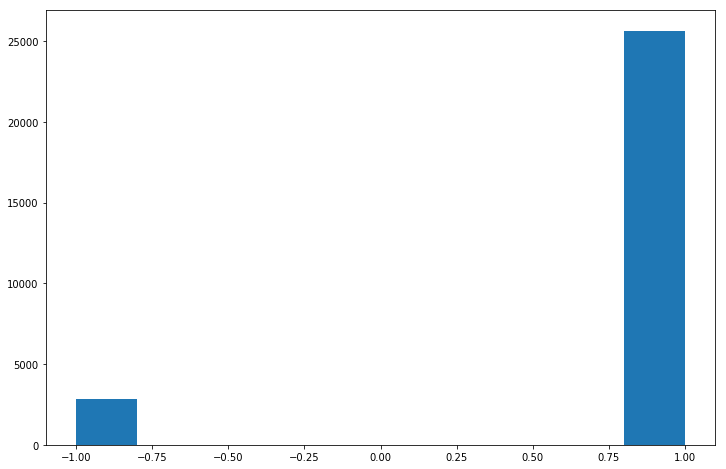

In [31]:
#Trying isolation forest to find out any outliers
from sklearn.ensemble import IsolationForest
clf  = IsolationForest(contamination=0.1, behaviour='new')
outliers = clf.fit_predict(telecom)
plt.figure(figsize=(12,8))
plt.hist(outliers);

## Summary of data understanding

In [32]:
print('Original Dataframe Shape: ', telecom_orig.shape); 
print("Original Dataframe Info: \n"); telecom_orig.info(); 
print("Original Dataframe Nulls:", telecom_orig.isnull().sum().sum()); 

print('Cleaned Dataframe Shape: ', telecom.shape); 
print("Cleaned Dataframe Info: \n"); telecom.info(); 
print("Cleaned Dataframe Nulls:", telecom.isnull().sum().sum()); 

Original Dataframe Shape:  (99999, 226)
Original Dataframe Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB
Original Dataframe Nulls: 3594931
Cleaned Dataframe Shape:  (28504, 144)
Cleaned Dataframe Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28504 entries, 7 to 99997
Columns: 144 entries, mobile_number to rech_days_left_8
dtypes: float64(105), int32(1), int64(26), uint8(12)
memory usage: 29.1 MB
Cleaned Dataframe Nulls: 0


## 2. Exploratory Data Analysis (EDA)

### Check data imbalance

In [33]:
#checking data imbalance
churn  = telecom["churn"].value_counts()
churn_rate = churn[1]/(churn[1] + churn[0])

print("Total Churn Count     = {}".format(churn[1]))
print("Total Not-Churn Count = {}".format(churn[0]))
print("Churn Rate            = {:.2f}%".format(churn_rate*100))

Total Churn Count     = 1596
Total Not-Churn Count = 26908
Churn Rate            = 5.60%


Observation: Data is highly imbalanced, we need to balance it before we can create the model

### Univariate Analysis on  'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8'

In [34]:
df_not_churn = telecom[telecom["churn"] == 0]
df_churn     = telecom[telecom["churn"] == 1]

In [35]:
#claculation of mean for churn or non churn
print("Mean:")
print(np.mean(df_not_churn["total_rech_num_6"]))
print(np.mean(df_churn["total_rech_num_6"]))
print("median:")
print(np.median(df_not_churn["total_rech_num_6"]))
print(np.median(df_churn["total_rech_num_6"]))

print("Quantiles:")
print(np.percentile(df_not_churn["total_rech_num_6"],np.arange(0,100,25)))
print(np.percentile(df_churn["total_rech_num_6"],np.arange(0,100,25)))

Mean:
11.826036866359447
14.31704260651629
median:
9.0
12.0
Quantiles:
[ 0.  6.  9. 14.]
[ 0.  8. 12. 18.]


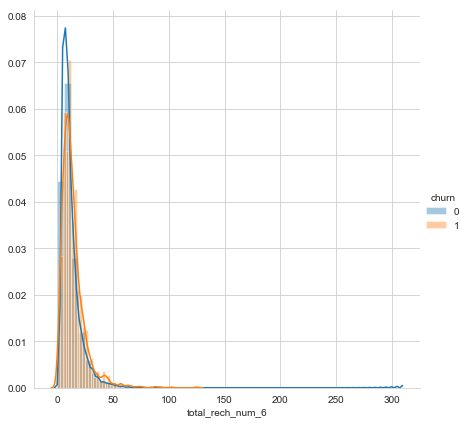

In [36]:
#feature importance of total_rech_num_6
#now use histogram or probability density function for univiraite analysis
#one variable analysis
#this is important to know feature importance in classification
sns.set_style('whitegrid')
sns.FacetGrid(telecom,hue='churn',size=6).map(sns.distplot,"total_rech_num_6").add_legend()

#its difficult to know about the churning rate based on total_rech_num_6 feature as overlaped data.

In [37]:
print("Mean:")
print(np.mean(df_not_churn["total_rech_num_7"]))
print(np.mean(df_churn["total_rech_num_7"]))
print("median:")
print(np.median(df_not_churn["total_rech_num_7"]))
print(np.median(df_churn["total_rech_num_7"]))

print("Quantiles:")
print(np.percentile(df_not_churn["total_rech_num_7"],np.arange(0,100,25)))
print(np.percentile(df_churn["total_rech_num_7"],np.arange(0,100,25)))

Mean:
11.875464545859968
13.43170426065163
median:
9.0
10.0
Quantiles:
[ 0.  6.  9. 15.]
[ 0.  7. 10. 17.]


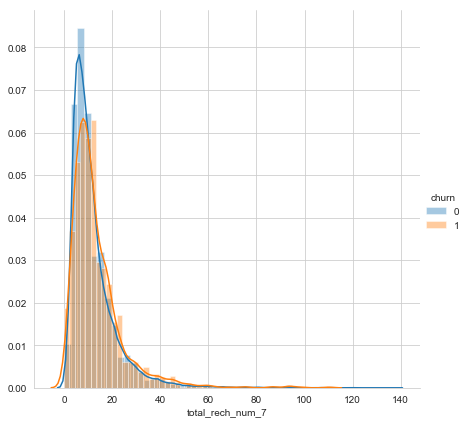

In [38]:
#feature importance of total_rech_data_7
#now use histogram or probability density function for univiraite analysis
#one variable analysis
#this is important to know feature importance in classification
sns.set_style('whitegrid')
sns.FacetGrid(telecom,hue='churn',size=6).map(sns.distplot,"total_rech_num_7").add_legend()

#its difficult to know about the churning rate based on total_rech_data_7 feature as overlaped data.

In [39]:
print("Mean:")
print(np.mean(df_not_churn["total_rech_num_8"]))
print(np.mean(df_churn["total_rech_num_8"]))
print("median:")
print(np.median(df_not_churn["total_rech_num_8"]))
print(np.median(df_churn["total_rech_num_8"]))

print("Quantiles:")
print(np.percentile(df_not_churn["total_rech_num_8"],np.arange(0,100,25)))
print(np.percentile(df_churn["total_rech_num_8"],np.arange(0,100,25)))

Mean:
10.523561766017542
7.021303258145363
median:
8.0
5.0
Quantiles:
[ 0.  5.  8. 13.]
[0. 3. 5. 9.]


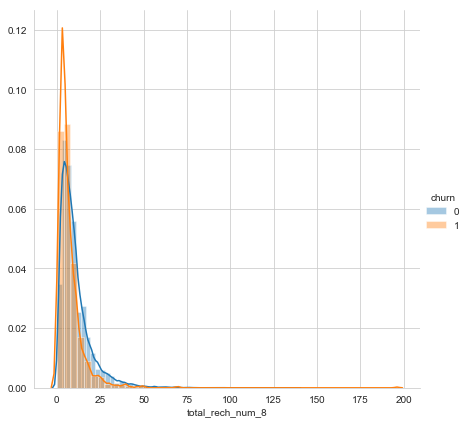

In [40]:
#feature importance of total_rech_amt_8
#now use histogram or probability density function for univiraite analysis
#one variable analysis
#this is important to know feature importance in classification
sns.FacetGrid(telecom,hue='churn',size=6).map(sns.distplot,"total_rech_num_8").add_legend()

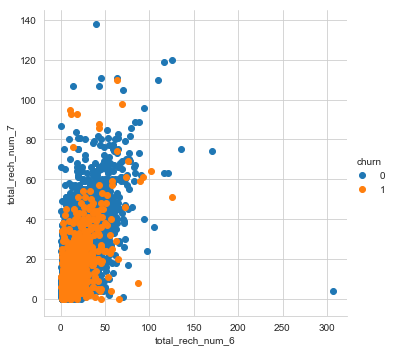

In [41]:
sns.FacetGrid(telecom,hue='churn',size=5).map(plt.scatter,"total_rech_num_6","total_rech_num_7").add_legend()

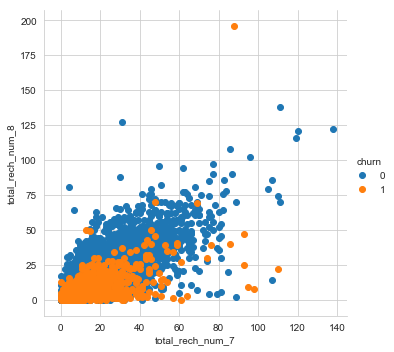

In [42]:
sns.FacetGrid(telecom,hue='churn',size=5).map(plt.scatter,"total_rech_num_7","total_rech_num_8").add_legend()

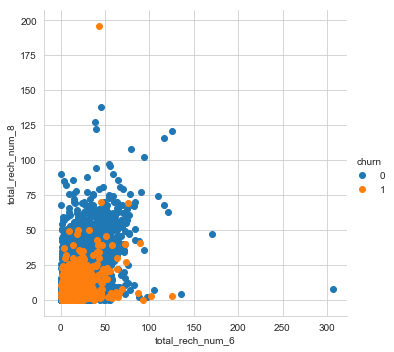

In [43]:
sns.FacetGrid(telecom,hue='churn',size=5).map(plt.scatter,"total_rech_num_6","total_rech_num_8").add_legend()

### Univariate Analysis on 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',

In [44]:
print("Mean:")
print(np.mean(df_not_churn["total_rech_amt_6"]))
print(np.mean(df_churn["total_rech_amt_6"]))
print("median:")
print(np.median(df_not_churn["total_rech_amt_6"]))
print(np.median(df_churn["total_rech_amt_6"]))

print("Quantiles:")
print(np.percentile(df_not_churn["total_rech_amt_6"],np.arange(0,100,25)))
print(np.percentile(df_churn["total_rech_amt_6"],np.arange(0,100,25)))

Mean:
656.1418537237996
786.3007518796992
median:
564.0
669.0
Quantiles:
[  0. 366. 564. 820.]
[  0. 450. 669. 984.]


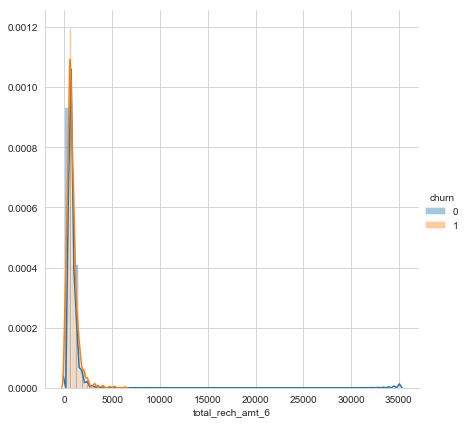

In [45]:
#feature importance of total_rech_num_6
#now use histogram or probability density function for univiraite analysis
#one variable analysis
#this is important to know feature importance in classification
sns.FacetGrid(telecom,hue='churn',size=6).map(sns.distplot,"total_rech_amt_6").add_legend()

In [46]:
print("Mean:")
print(np.mean(df_not_churn["total_rech_amt_7"]))
print(np.mean(df_churn["total_rech_amt_7"]))
print("median:")
print(np.median(df_not_churn["total_rech_amt_7"]))
print(np.median(df_churn["total_rech_amt_7"]))

print("Quantiles:")
print(np.percentile(df_not_churn["total_rech_amt_7"],np.arange(0,100,25)))
print(np.percentile(df_churn["total_rech_amt_7"],np.arange(0,100,25)))

Mean:
668.5358257767207
733.1115288220551
median:
570.0
616.0
Quantiles:
[  0. 366. 570. 833.]
[  0.   382.75 616.   939.25]


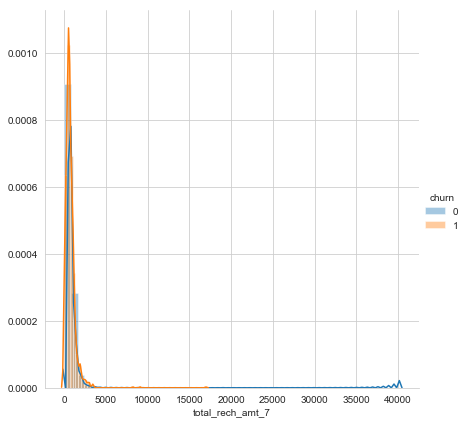

In [47]:
#feature importance of total_rech_num_6
#now use histogram or probability density function for univiraite analysis
#one variable analysis
#this is important to know feature importance in classification
sns.FacetGrid(telecom,hue='churn',size=6).map(sns.distplot,"total_rech_amt_7").add_legend()

In [48]:
print("Mean:")
print(np.mean(df_not_churn["total_rech_amt_8"]))
print(np.mean(df_churn["total_rech_amt_8"]))
print("median:")
print(np.median(df_not_churn["total_rech_amt_8"]))
print(np.median(df_churn["total_rech_amt_8"]))

print("Quantiles:")
print(np.percentile(df_not_churn["total_rech_amt_8"],np.arange(0,100,25)))
print(np.percentile(df_churn["total_rech_amt_8"],np.arange(0,100,25)))

Mean:
619.713691095585
352.98809523809524
median:
518.0
190.0
Quantiles:
[  0. 288. 518. 800.]
[  0.    16.5  190.   506.25]


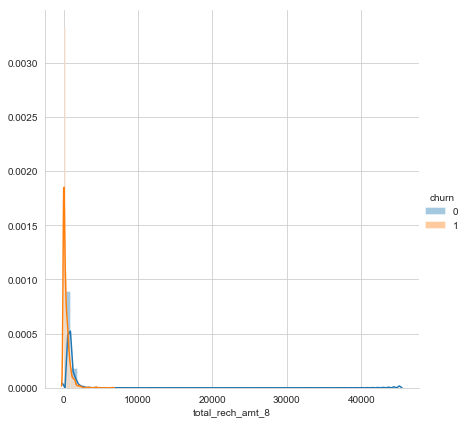

In [49]:
#feature importance of total_rech_num_6
#now use histogram or probability density function for univiraite analysis
#one variable analysis
#this is important to know feature importance in classification
sns.FacetGrid(telecom,hue='churn',size=6).map(sns.distplot,"total_rech_amt_8").add_legend()

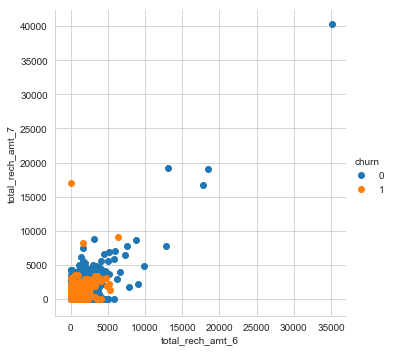

In [50]:
sns.FacetGrid(telecom,hue='churn',size=5).map(plt.scatter,"total_rech_amt_6","total_rech_amt_7").add_legend()

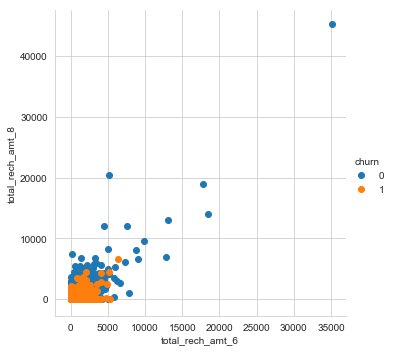

In [51]:
sns.FacetGrid(telecom,hue='churn',size=5).map(plt.scatter,"total_rech_amt_6","total_rech_amt_8").add_legend()

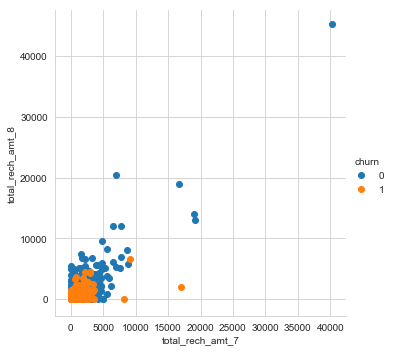

In [52]:
sns.FacetGrid(telecom,hue='churn',size=5).map(plt.scatter,"total_rech_amt_7","total_rech_amt_8").add_legend()

### Univariate Analysis on max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',

In [53]:
print("Mean:")
print(np.mean(df_not_churn["max_rech_amt_6"]))
print(np.mean(df_churn["max_rech_amt_6"]))
print("median:")
print(np.median(df_not_churn["max_rech_amt_6"]))
print(np.median(df_churn["max_rech_amt_6"]))

print("Quantiles:")
print(np.percentile(df_not_churn["max_rech_amt_6"],np.arange(0,100,25)))
print(np.percentile(df_churn["max_rech_amt_6"],np.arange(0,100,25)))

Mean:
168.3110227441653
158.79761904761904
median:
120.0
110.0
Quantiles:
[  0. 110. 120. 200.]
[  0. 100. 110. 154.]


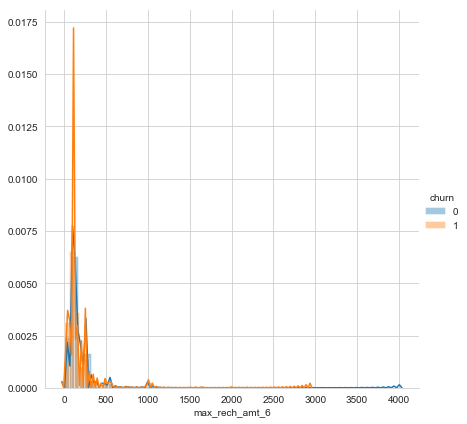

In [54]:
sns.FacetGrid(telecom,hue='churn',size=6).map(sns.distplot,"max_rech_amt_6").add_legend()

In [55]:
print("Mean:")
print(np.mean(df_not_churn["max_rech_amt_7"]))
print(np.mean(df_churn["max_rech_amt_7"]))
print("median:")
print(np.median(df_not_churn["max_rech_amt_7"]))
print(np.median(df_churn["max_rech_amt_7"]))

print("Quantiles:")
print(np.percentile(df_not_churn["max_rech_amt_7"],np.arange(0,100,25)))
print(np.percentile(df_churn["max_rech_amt_7"],np.arange(0,100,25)))

Mean:
171.94440315147912
159.51629072681703
median:
130.0
110.0
Quantiles:
[  0. 110. 130. 200.]
[  0.  98. 110. 154.]


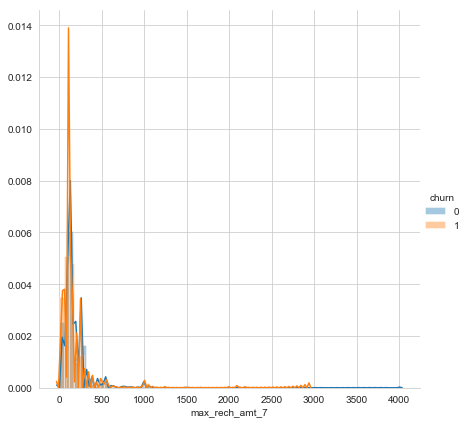

In [56]:
sns.FacetGrid(telecom,hue='churn',size=6).map(sns.distplot,"max_rech_amt_7").add_legend()

In [57]:
print("Mean:")
print(np.mean(df_not_churn["max_rech_amt_8"]))
print(np.mean(df_churn["max_rech_amt_8"]))
print("median:")
print(np.median(df_not_churn["max_rech_amt_8"]))
print(np.median(df_churn["max_rech_amt_8"]))

print("Quantiles:")
print(np.percentile(df_not_churn["max_rech_amt_8"],np.arange(0,100,25)))
print(np.percentile(df_churn["max_rech_amt_8"],np.arange(0,100,25)))

Mean:
166.4161959268619
111.0983709273183
median:
144.0
56.0
Quantiles:
[  0.  70. 144. 198.]
[  0.  10.  56. 130.]


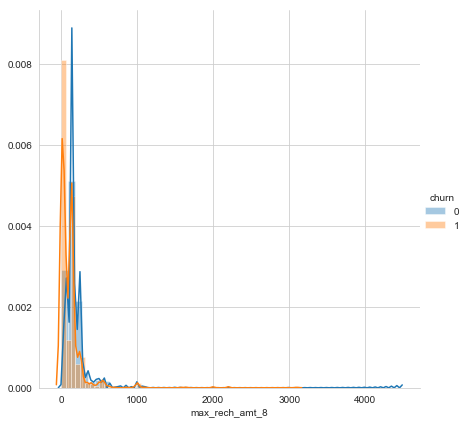

In [58]:
sns.FacetGrid(telecom,hue='churn',size=6).map(sns.distplot,"max_rech_amt_8").add_legend()

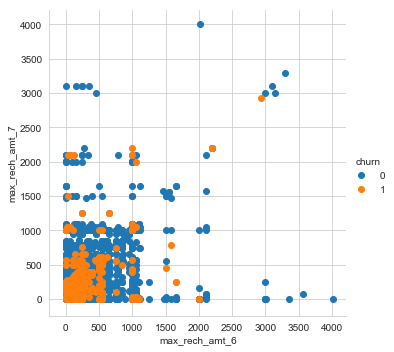

In [59]:
sns.FacetGrid(telecom,hue='churn',size=5).map(plt.scatter,"max_rech_amt_6","max_rech_amt_7").add_legend()

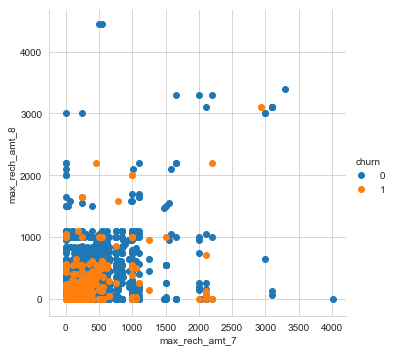

In [60]:
sns.FacetGrid(telecom,hue='churn',size=5).map(plt.scatter,"max_rech_amt_7","max_rech_amt_8").add_legend()

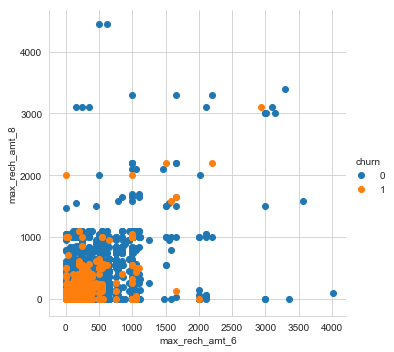

In [61]:
sns.FacetGrid(telecom,hue='churn',size=5).map(plt.scatter,"max_rech_amt_6","max_rech_amt_8").add_legend()

Note: due to space & size we did not include all univariate and bivariate analysis in this file.

### Correlation Matrix: Bivariate Analysis

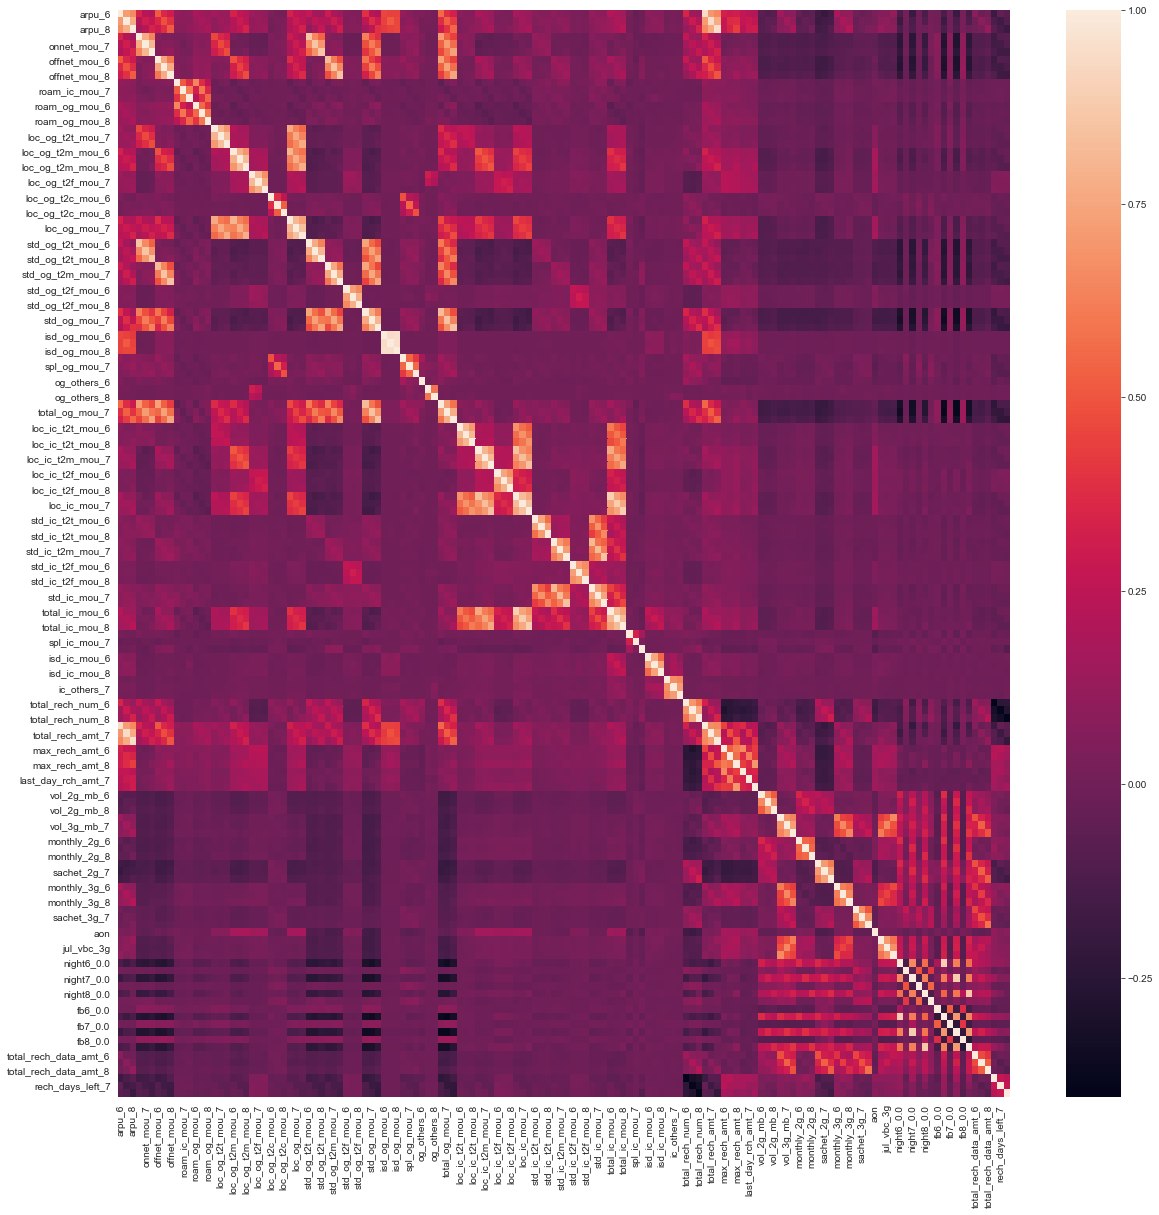

In [62]:
telecom2 = telecom.drop(['mobile_number', 'churn'], axis=1)

# Let's see the correlation matrix 
plt.figure(figsize = (20,20))        # Size of the figure
sns.heatmap(telecom2.corr())

In [63]:
# Create correlation matrix
corr_matrix = telecom2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.80
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.80)]

print("HIGHLY CORRELATED FEATURES IN DATA SET:{}\n\n{}".format(len(high_corr_features), high_corr_features))

HIGHLY CORRELATED FEATURES IN DATA SET:36

['onnet_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_7', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'isd_og_mou_7', 'isd_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'fb6_1.0', 'fb7_1.0', 'fb8_1.0']


* Observation: 36 highly correlated features with > 80% as correlation factor in the data set.

## Summary of EDA

Observations
1. Data is higly imbalanced with only 5.6% churn rate & remaining non-churn
2. Univariate analysis doesn't show a clear indicator towards churn.
3. There are 36 highly correlated features with more then 0.8 correlation factor.

Further steps to perform:
1. Class imabalance needs to be handled
2. Feture reduction needs to be performed before modelling using PCA.

## Model building

In [64]:
# Putting feature variable to X
X = telecom.drop(['churn','mobile_number'],axis=1)

# Putting response variable to y
y = telecom['churn']

In [65]:
# create a feature data frame copy from original features
X_diff = X.copy()

## feature standardisation

In [66]:
# import standard scalar
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# extract columns
cols = X_diff.columns

# apply standard scalar
scaler = StandardScaler()

# produce scaled features
X_scaled = scaler.fit_transform(X_diff)

# convert to data frame
X_scaled = pd.DataFrame(X_diff, columns=cols)

In [67]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, train_size=0.7,test_size=0.3,random_state=100)


Function to print out evaluation metrics

In [68]:
from sklearn.metrics import confusion_matrix,roc_auc_score,f1_score

# define function to calculate and print model metrics.
def printMetrics(y_test,y_pred):
    cp = confusion_matrix(y_test,y_pred)
    sensitivity = cp[1,1]/(cp[1,0]+cp[1,1])
    specificity =  cp[0,0]/(cp[0,1]+cp[0,0])
    precision = cp[1,1]/(cp[0,1]+cp[1,1])
    print('Confusion Matrix: \n',cp)
    print("Sensitivity: ", sensitivity)
    print("Specificity: ",specificity)
    print("AUC Score: ", roc_auc_score(y_test,y_pred)) 
    print("Precision: ",precision)
    print("f1 Score: ",f1_score(y_test,y_pred))

In [69]:
# let's start by building as basic logistic regression model
from sklearn.linear_model import LogisticRegression
lsr = LogisticRegression()

In [70]:
lsr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [71]:
# predict results on test
y_pred = lsr.predict(X_test)

In [72]:
# print model evaluation metrics
printMetrics(y_test,y_pred)


Confusion Matrix: 
 [[8013   61]
 [ 403   75]]
Sensitivity:  0.15690376569037656
Specificity:  0.992444884815457
AUC Score:  0.5746743252529168
Precision:  0.5514705882352942
f1 Score:  0.24429967426710095


We do see from above that the Sensitivity and AUC score is pretty low, this is because the data imbalanced with only 5.60% values for churn. Need to imbalanced class handling

## Imbalanced class handling

SMOTE resampling: by generating synthetic samples for the minority class.

### SMOTE resampling

In [73]:
# import SMOTE sampler from imblearn library
from imblearn.over_sampling import SMOTE
smote = SMOTE(kind = "regular")

In [74]:
# SMOTE sampling the training data
X_sm, y_sm = smote.fit_sample(X_train, y_train)

In [75]:
lsr = LogisticRegression()
lsr.fit(X_sm,y_sm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
y_pred = lsr.predict(X_test)
printMetrics(y_test,y_pred)

Confusion Matrix: 
 [[6666 1408]
 [  93  385]]
Sensitivity:  0.805439330543933
Specificity:  0.8256130790190735
AUC Score:  0.8155262047815032
Precision:  0.2147239263803681
f1 Score:  0.3390576838397182


## 3a. Diminsion Reduction with PCA

Number of features are quite high, let's try dimensionality reduction with PCA and try model creation on reduced feature set.

In [77]:
from sklearn.decomposition import PCA

In [78]:
pca = PCA(svd_solver='randomized', random_state=101)

In [79]:
pca.fit(X_sm)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=101,
    svd_solver='randomized', tol=0.0, whiten=False)

In [194]:
# let's check the features with top PCA components
colnames = list(X_scaled.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head(10)

,PC1,PC2,Feature
0,-0.07,0.13,arpu_6
1,-0.06,0.16,arpu_7
2,-0.03,0.13,arpu_8
3,-0.11,0.12,onnet_mou_6
4,-0.12,0.13,onnet_mou_7
5,-0.07,0.10,onnet_mou_8
6,-0.13,0.13,offnet_mou_6
7,-0.13,0.15,offnet_mou_7
8,-0.07,0.10,offnet_mou_8
9,-0.00,-0.00,roam_ic_mou_6


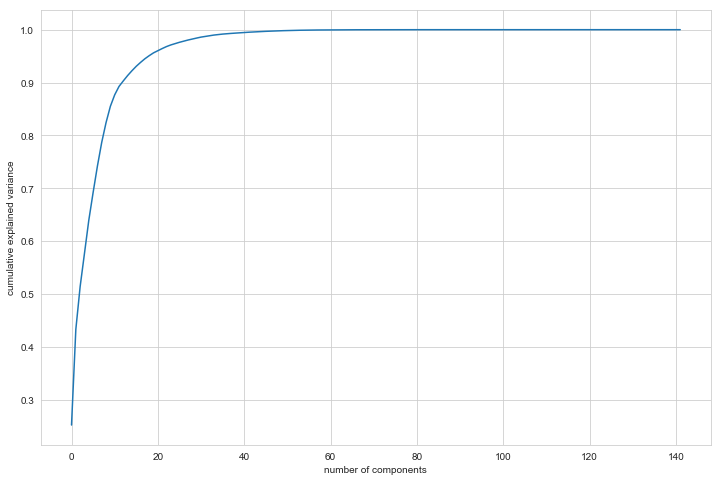

In [81]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

We see approximately 50 features capture maximum variance

In [82]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA

pca_final = IncrementalPCA(n_components=50)

In [83]:
X_train_pca = pca_final.fit_transform(X_sm)

X_train_pca.shape

(37668, 50)

In [84]:
X_test_pca = pca_final.transform(X_test)
X_test_pca.shape

(8552, 50)

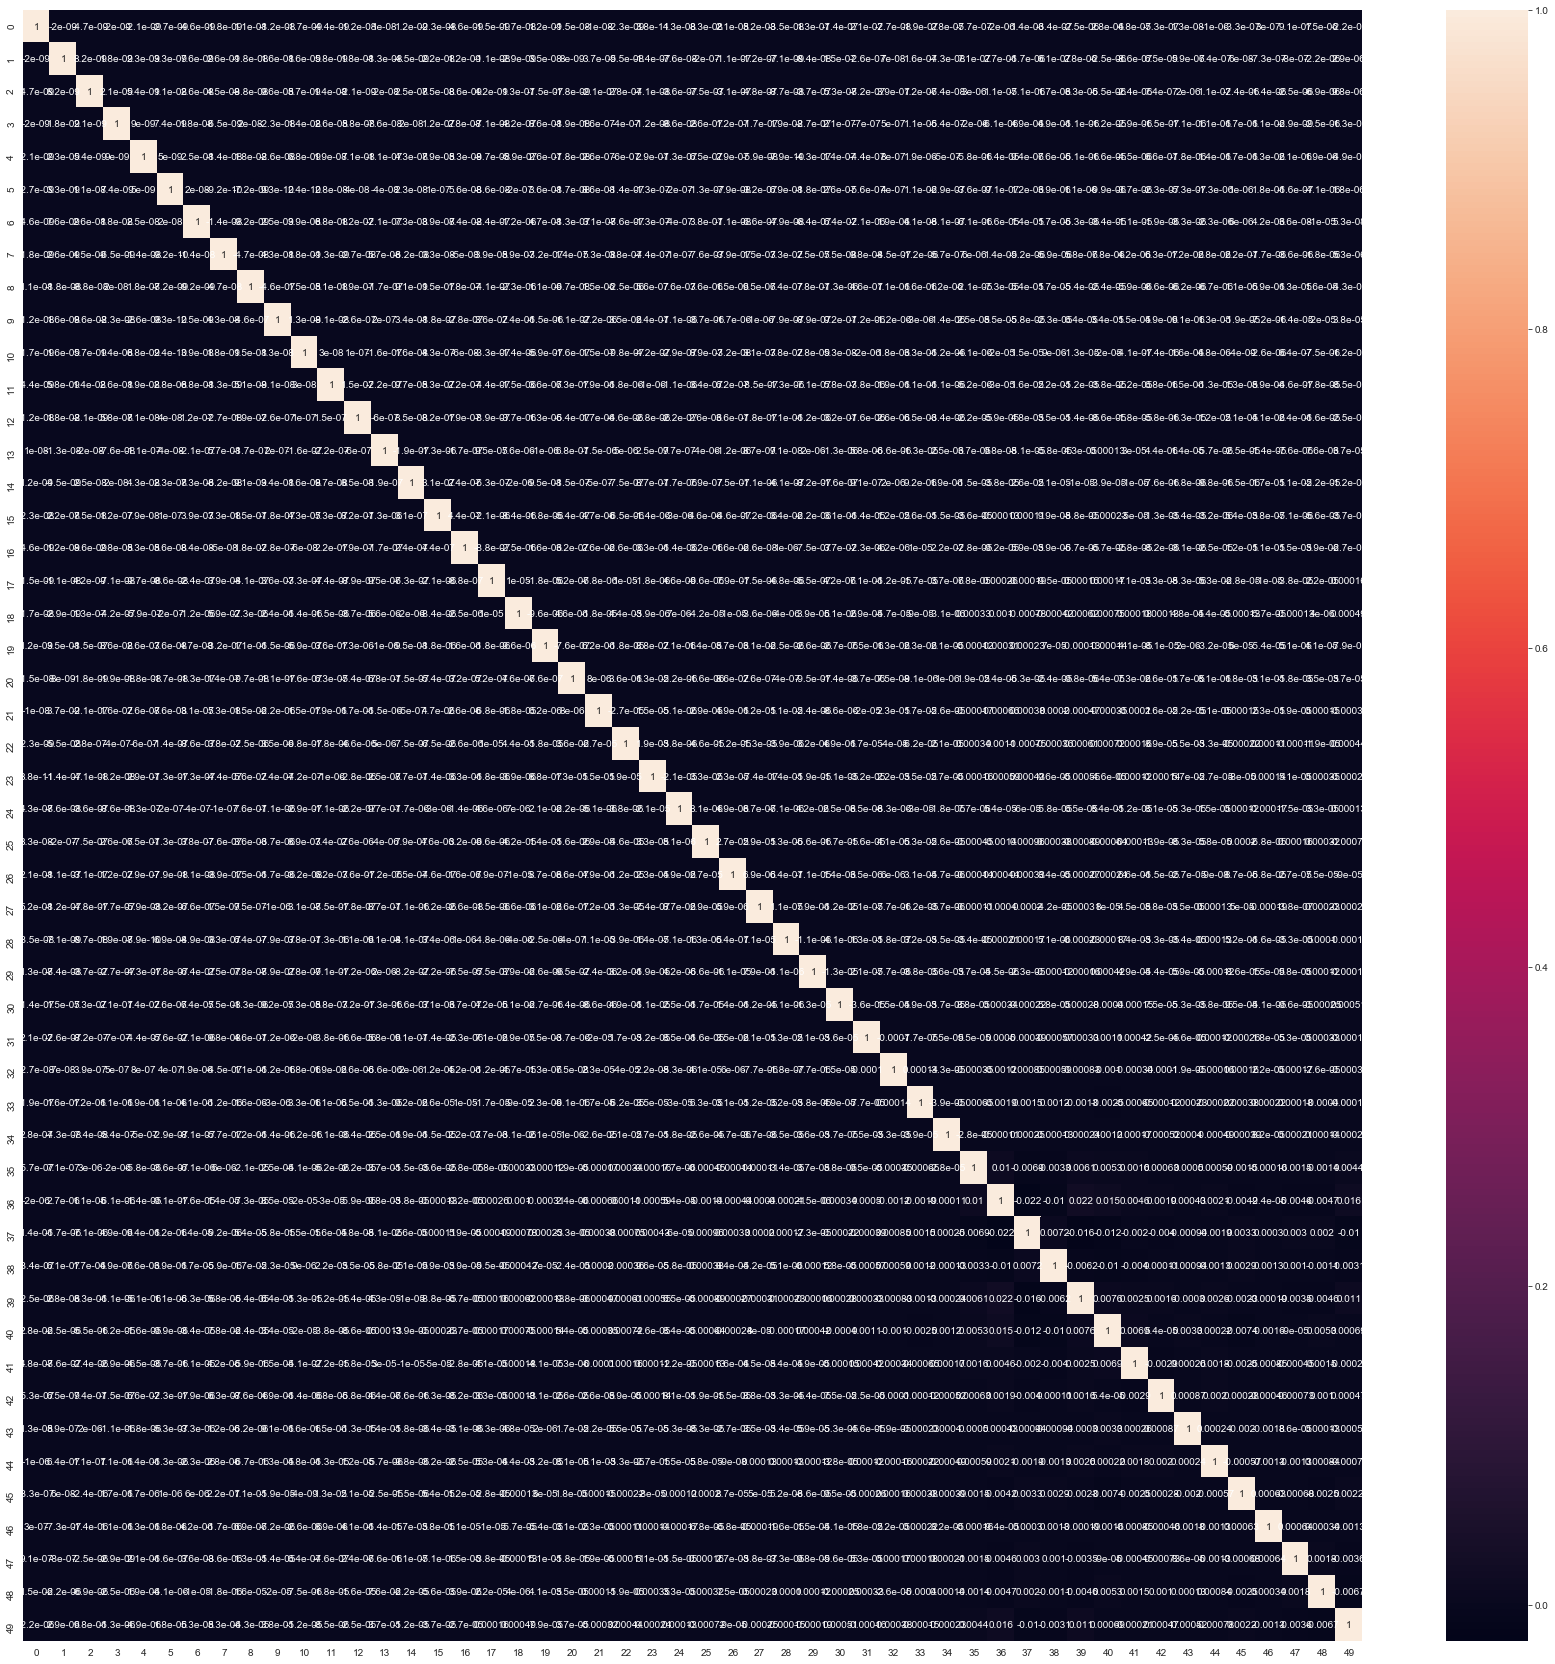

In [85]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(X_train_pca.transpose())

#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (30,30))
sns.heatmap(corrmat,annot = True)

In [86]:
lr_pca = LogisticRegression()
model_pca = lr_pca.fit(X_train_pca,y_sm)

In [87]:
y_pred = lr_pca.predict(X_test_pca)

In [88]:
printMetrics(y_test,y_pred)

Confusion Matrix: 
 [[6425 1649]
 [  85  393]]
Sensitivity:  0.8221757322175732
Specificity:  0.7957641813227644
AUC Score:  0.8089699567701689
Precision:  0.19245837414299707
f1 Score:  0.3119047619047619


#### Adjusting probability threshold cutoff for logistic regression


We will now try to select the optimum probability threshold for the model

In [89]:
# check the predicted probabilities
y_pred_prob = lr_pca.predict_proba(X_test_pca)

In [90]:
# create predicted probability data frame
y_pred_prob_df = pd.DataFrame(y_pred_prob)
y_pred_prob_df = y_pred_prob_df.iloc[:,[1]]

y_test_df = pd.DataFrame(y_test)
y_test_df['ID'] = y_test_df.index

y_pred_prob_df.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_prob_df
y_pred_final = pd.concat([y_test_df,y_pred_prob_df],axis=1)

In [91]:
# renaming column
y_pred_final= y_pred_final.rename(columns={ 1 : 'Churn_Prob'})
y_pred_final.head()


,churn,ID,Churn_Prob
0,0,23592,0.04
1,0,29640,0.33
2,0,11357,0.52
3,0,37103,0.14
4,0,17466,0.07


In [92]:
# Rearranging the columns
y_pred_final = y_pred_final.reindex_axis(['ID','churn','Churn_Prob'], axis=1)
y_pred_final.head()

,ID,churn,Churn_Prob
0,23592,0,0.04
1,29640,0,0.33
2,11357,0,0.52
3,37103,0,0.14
4,17466,0,0.07


In [93]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Churn_Prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()


,ID,churn,Churn_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,23592,0,0.04,1,0,0,0,0,0,0,0,0,0
1,29640,0,0.33,1,1,1,1,0,0,0,0,0,0
2,11357,0,0.52,1,1,1,1,1,1,0,0,0,0
3,37103,0,0.14,1,1,0,0,0,0,0,0,0,0
4,17466,0,0.07,1,0,0,0,0,0,0,0,0,0


In [94]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','speci','sensi','preci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    Precision = cm1[1,1]/(cm1[0,1]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,Specificity,Sensitivity,Precision]
print(cutoff_df)

      prob  accuracy  speci  sensi  preci
0.00  0.00      0.06   0.00   1.00   0.06
0.10  0.10      0.34   0.31   0.97   0.08
0.20  0.20      0.50   0.47   0.95   0.10
0.30  0.30      0.61   0.59   0.91   0.12
0.40  0.40      0.71   0.70   0.87   0.15
0.50  0.50      0.80   0.80   0.82   0.19
0.60  0.60      0.86   0.87   0.75   0.25
0.70  0.70      0.90   0.92   0.65   0.32
0.80  0.80      0.93   0.95   0.47   0.38
0.90  0.90      0.94   0.98   0.25   0.44


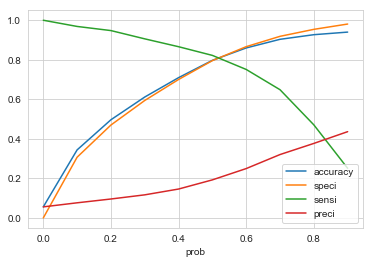

In [95]:
# Graph for plotting accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','speci','sensi','preci'])

In [96]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.51 else 0)
y_pred_final

,ID,churn,Churn_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,23592,0,0.04,1,0,0,0,0,0,0,0,0,0,0
1,29640,0,0.33,1,1,1,1,0,0,0,0,0,0,0
2,11357,0,0.52,1,1,1,1,1,1,0,0,0,0,1
3,37103,0,0.14,1,1,0,0,0,0,0,0,0,0,0
4,17466,0,0.07,1,0,0,0,0,0,0,0,0,0,0
5,19210,0,0.17,1,1,0,0,0,0,0,0,0,0,0
6,49970,0,0.56,1,1,1,1,1,1,0,0,0,0,1
7,62178,0,0.00,1,0,0,0,0,0,0,0,0,0,0
8,78564,0,0.18,1,1,0,0,0,0,0,0,0,0,0
9,41544,0,0.13,1,1,0,0,0,0,0,0,0,0,0


## Baseline Model

In [97]:
#Let's check the overall accuracy.
#print(accuracy_score(y_test,y_pred)
printMetrics(y_pred_final.churn, y_pred_final.final_predicted)

Confusion Matrix: 
 [[6492 1582]
 [  88  390]]
Sensitivity:  0.8158995815899581
Specificity:  0.804062422591033
AUC Score:  0.8099810020904955
Precision:  0.19776876267748478
f1 Score:  0.31836734693877544


## 3b. Decision tree

In [98]:
telecom.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,fb7_1.0,fb8_0.0,fb8_1.0,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,churn,rech_days_left_6,rech_days_left_7,rech_days_left_8
7,7000701601,1069.18,1349.85,3171.48,57.84,54.68,52.29,453.43,567.16,325.91,...,0,0,0,0.00,0.00,0.00,1,3.00,6.00,5.00
8,7001524846,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,...,1,0,1,0.00,354.00,207.00,0,5.00,0.00,1.00
21,7002124215,514.45,597.75,637.76,102.41,132.11,85.14,757.93,896.68,983.39,...,0,0,0,0.00,0.00,0.00,0,0.00,0.00,0.00
23,7000887461,74.35,193.90,366.97,48.96,50.66,33.58,85.41,89.36,205.89,...,1,0,1,0.00,712.00,540.00,0,12.00,24.00,7.00
33,7000149764,977.02,2362.83,409.23,0.00,0.00,0.00,0.00,0.00,0.00,...,1,0,1,5285.00,20424.00,455.00,0,0.00,1.00,5.00


In [99]:
X_DT = telecom.drop(['mobile_number','churn'], axis=1)
y_DT = telecom['churn']

In [100]:
X_DT.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,fb7_0.0,fb7_1.0,fb8_0.0,fb8_1.0,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,rech_days_left_6,rech_days_left_7,rech_days_left_8
7,1069.18,1349.85,3171.48,57.84,54.68,52.29,453.43,567.16,325.91,16.23,...,0,0,0,0,0.00,0.00,0.00,3.00,6.00,5.00
8,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,...,0,1,0,1,0.00,354.00,207.00,5.00,0.00,1.00
21,514.45,597.75,637.76,102.41,132.11,85.14,757.93,896.68,983.39,0.00,...,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00
23,74.35,193.90,366.97,48.96,50.66,33.58,85.41,89.36,205.89,0.00,...,0,1,0,1,0.00,712.00,540.00,12.00,24.00,7.00
33,977.02,2362.83,409.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,1,0,1,5285.00,20424.00,455.00,0.00,1.00,5.00


In [101]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


scaler = preprocessing.StandardScaler().fit(X_DT)
x_DT_tr = scaler.transform(X_DT)

In [102]:
print(x_DT_tr)

[[ 1.13331601  1.62315019  5.28296718 ... -0.0860962   0.58711994
   0.16996872]
 [-0.4046175  -0.1633225  -0.77623658 ...  0.35949364 -0.81289122
  -0.61725773]
 [-0.10228704  0.05650088  0.22306979 ... -0.75448095 -0.81289122
  -0.81406434]
 ...
 [ 0.18843418 -0.24038462  0.07643637 ...  1.47346822 -0.11288564
   1.74442161]
 [-0.55198946 -0.12018479 -0.24758862 ... -0.75448095 -0.11288564
  -0.42045112]
 [-0.52875092 -0.55667782  0.16127591 ...  2.14185297  1.9871311
   1.35080839]]


In [103]:
# Importing train-test-split 
from sklearn.model_selection import train_test_split

# Splitting the data into train and test
x_DT_train, x_DT_test, y_DT_train, y_DT_test = train_test_split(x_DT_tr, y_DT, 
                                                    test_size=0.30, 
                                                    random_state = 99)

In [104]:
print("X_train Dataframe Shape {}".format(x_DT_train.shape))
print("X_test Dataframe Shape {}".format(x_DT_test.shape))

y_train_imb = (y_DT_train != 0).sum()/(y_DT_train == 0).sum()
y_test_imb = (y_DT_test != 0).sum()/(y_DT_test == 0).sum()
print("Imbalance in Train Data: {}".format(y_train_imb))
print("Imbalance in Test Data: {}".format(y_test_imb))

X_train Dataframe Shape (19952, 142)
X_test Dataframe Shape (8552, 142)
Imbalance in Train Data: 0.058293109849891264
Imbalance in Test Data: 0.0617008069522036


### Balance data set by oversampling

In [105]:
x_DT_bal_train,y_DT_bal_train = smote.fit_sample(x_DT_train,y_DT_train)

In [106]:
print("x_DT_bal_train Dataframe Shape {}".format(x_DT_bal_train.shape))
print("y_DT_bal_train Dataframe Shape {}".format(y_DT_bal_train.shape))

data_imbalance = (y_DT_bal_train != 0).sum()/(y_DT_bal_train == 0).sum()
print("Imbalance in Train Data: {}".format(data_imbalance))

x_DT_bal_train Dataframe Shape (37706, 142)
y_DT_bal_train Dataframe Shape (37706,)
Imbalance in Train Data: 1.0


In [107]:
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(max_depth=5)
dt_default.fit(x_DT_bal_train, y_DT_bal_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [108]:
# Let's check the evaluation metrics of our default model

# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
y_DT_pred_default = dt_default.predict(x_DT_test)

# Printing classification report
print(classification_report(y_DT_test, y_DT_pred_default))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      8055
           1       0.27      0.73      0.39       497

    accuracy                           0.87      8552
   macro avg       0.63      0.81      0.66      8552
weighted avg       0.94      0.87      0.90      8552



In [109]:
# Printing confusion matrix and accuracy
print(confusion_matrix(y_DT_test,y_DT_pred_default))
print(accuracy_score(y_DT_test,y_DT_pred_default))

[[7064  991]
 [ 132  365]]
0.8686856875584659


In [110]:
# Importing required packages for visualization
#from IPython.display import Image  
#from sklearn.externals.six import StringIO   
#from sklearn.tree import export_graphviz
#import pydotplus, graphviz

# Putting features
#features = list(X_DT.columns)
#features

In [111]:
# plotting tree with max_depth=3
#dot_data = StringIO()  
#export_graphviz(dt_default, out_file=dot_data,
#                feature_names=features, filled=True,rounded=True)

#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png())

### Tuning max_depth

In [112]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(x_DT_bal_train, y_DT_bal_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None, param_grid={'max_depth': range(1, 40)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='

In [113]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.74,0.04,0.01,0.00,1,{'max_depth': 1},0.79,0.80,0.81,0.80,...,0.80,0.01,39,0.81,0.80,0.80,0.80,0.80,0.80,0.00
1,1.31,0.02,0.01,0.00,2,{'max_depth': 2},0.81,0.84,0.83,0.83,...,0.83,0.01,38,0.84,0.83,0.82,0.83,0.83,0.83,0.00
2,1.91,0.06,0.01,0.01,3,{'max_depth': 3},0.83,0.85,0.85,0.84,...,0.85,0.01,37,0.85,0.85,0.84,0.85,0.85,0.85,0.00
3,2.45,0.01,0.01,0.00,4,{'max_depth': 4},0.85,0.87,0.88,0.87,...,0.87,0.01,36,0.87,0.87,0.87,0.87,0.87,0.87,0.00
4,3.03,0.08,0.02,0.00,5,{'max_depth': 5},0.86,0.89,0.89,0.89,...,0.88,0.01,35,0.90,0.89,0.89,0.89,0.89,0.89,0.00


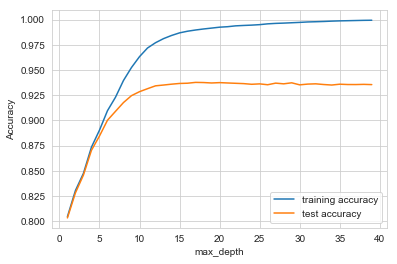

In [114]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Tuning min_samples_leaf

In [115]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(x_DT_bal_train, y_DT_bal_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': range(5, 200, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Tru

In [116]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,9.41,0.31,0.01,0.00,5,{'min_samples_leaf': 5},0.90,0.94,0.94,0.94,...,0.93,0.02,1,0.98,0.97,0.98,0.98,0.98,0.98,0.00
1,7.64,0.46,0.02,0.00,25,{'min_samples_leaf': 25},0.89,0.92,0.92,0.92,...,0.92,0.02,2,0.95,0.94,0.94,0.94,0.94,0.94,0.00
2,6.66,0.13,0.01,0.01,45,{'min_samples_leaf': 45},0.88,0.92,0.91,0.92,...,0.91,0.02,3,0.93,0.93,0.92,0.92,0.92,0.93,0.00
3,6.29,0.21,0.01,0.01,65,{'min_samples_leaf': 65},0.88,0.91,0.91,0.91,...,0.90,0.01,4,0.93,0.92,0.91,0.92,0.91,0.92,0.00
4,5.89,0.10,0.01,0.01,85,{'min_samples_leaf': 85},0.88,0.91,0.90,0.91,...,0.90,0.01,5,0.92,0.91,0.91,0.91,0.91,0.91,0.00


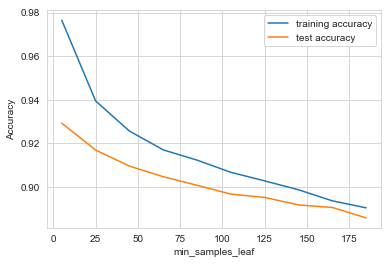

In [117]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Tuning min_samples_split

In [118]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(x_DT_bal_train, y_DT_bal_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_split': range(5, 200, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Tr

In [119]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,11.15,0.34,0.02,0.00,5,{'min_samples_split': 5},0.90,0.94,0.94,0.94,...,0.93,0.02,1,1.00,1.00,1.00,1.00,1.00,1.00,0.00
1,11.18,0.46,0.02,0.00,25,{'min_samples_split': 25},0.89,0.94,0.93,0.93,...,0.93,0.02,2,0.98,0.98,0.98,0.98,0.98,0.98,0.00
2,11.20,0.29,0.02,0.00,45,{'min_samples_split': 45},0.89,0.93,0.93,0.93,...,0.92,0.02,3,0.97,0.96,0.96,0.96,0.96,0.96,0.00
3,11.12,0.41,0.01,0.01,65,{'min_samples_split': 65},0.88,0.93,0.93,0.93,...,0.92,0.02,4,0.96,0.96,0.96,0.95,0.96,0.96,0.00
4,10.98,0.38,0.01,0.00,85,{'min_samples_split': 85},0.88,0.93,0.92,0.92,...,0.92,0.02,5,0.96,0.95,0.95,0.95,0.95,0.95,0.00


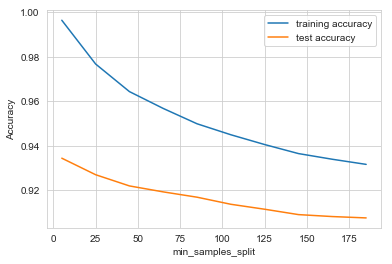

In [120]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Grid Search to Find Optimal Hyperparameters

In [121]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1, return_train_score=True)

# Fit the grid search to the data
grid_search.fit(x_DT_bal_train,y_DT_bal_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  6.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 5),
                      

In [122]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.78,0.39,0.01,0.00,entropy,5,50,50,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.86,...,0.89,0.01,9,0.90,0.88,0.89,0.89,0.88,0.89,0.01
1,4.52,0.07,0.01,0.01,entropy,5,50,100,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.86,...,0.89,0.01,9,0.90,0.88,0.89,0.89,0.88,0.89,0.01
2,4.40,0.02,0.01,0.01,entropy,5,100,50,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.86,...,0.88,0.01,13,0.89,0.88,0.89,0.88,0.88,0.88,0.01
3,4.40,0.01,0.01,0.01,entropy,5,100,100,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.86,...,0.88,0.01,13,0.89,0.88,0.89,0.88,0.88,0.88,0.01
4,7.21,0.07,0.01,0.00,entropy,10,50,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.88,...,0.91,0.02,2,0.93,0.93,0.93,0.93,0.92,0.93,0.00
5,7.21,0.07,0.01,0.01,entropy,10,50,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.88,...,0.91,0.02,1,0.93,0.93,0.93,0.93,0.92,0.93,0.00
6,6.77,0.07,0.01,0.00,entropy,10,100,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.87,...,0.90,0.02,5,0.92,0.91,0.91,0.91,0.91,0.91,0.00
7,6.79,0.07,0.01,0.00,entropy,10,100,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.87,...,0.90,0.02,5,0.92,0.91,0.91,0.91,0.91,0.91,0.00
8,2.95,0.01,0.02,0.00,gini,5,50,50,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.86,...,0.88,0.01,11,0.90,0.89,0.88,0.89,0.89,0.89,0.00
9,2.96,0.01,0.01,0.01,gini,5,50,100,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.86,...,0.88,0.01,11,0.90,0.89,0.88,0.89,0.89,0.89,0.00


In [123]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

best accuracy 0.9129316289184745
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


**Running the model with best parameters obtained from grid search.**

In [124]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)
clf_gini.fit(x_DT_bal_train, y_DT_bal_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

In [125]:
# accuracy score
clf_gini.score(x_DT_test,y_DT_test)

0.887511693171188

In [126]:
# plotting the tree
#dot_data = StringIO()  
#export_graphviz(clf_gini, out_file=dot_data,feature_names=features,filled=True,rounded=True)


#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png())

In [127]:
# tree with max_depth = 3
#clf_gini = DecisionTreeClassifier(criterion = "gini", 
#                                  random_state = 100,
#                                  max_depth=10, 
#                                  min_samples_leaf=100,
#                                  min_samples_split=50)
#clf_gini.fit(x_DT_bal_train, y_DT_bal_train)

# score
#print(clf_gini.score(x_DT_test,y_DT_test))

In [128]:
# plotting tree with max_depth=3
#dot_data = StringIO()  
#export_graphviz(clf_gini, out_file=dot_data,feature_names=features,filled=True,rounded=True)

#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png())

In [129]:
# classification metrics
from sklearn.metrics import classification_report,confusion_matrix
y_DT_pred = clf_gini.predict(x_DT_test)
print(classification_report(y_DT_test, y_DT_pred))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      8055
           1       0.29      0.67      0.41       497

    accuracy                           0.89      8552
   macro avg       0.64      0.78      0.67      8552
weighted avg       0.94      0.89      0.91      8552



In [130]:
# confusion matrix
print(confusion_matrix(y_DT_test,y_DT_pred))

[[7259  796]
 [ 166  331]]


In [131]:
 from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_DT_test, y_DT_pred))

Accuracy: 0.887511693171188


In [132]:
printMetrics(y_DT_test, y_DT_pred)

Confusion Matrix: 
 [[7259  796]
 [ 166  331]]
Sensitivity:  0.6659959758551308
Specificity:  0.901179391682185
AUC Score:  0.783587683768658
Precision:  0.2937000887311446
f1 Score:  0.40763546798029554


## 3c. Random Forest 

In [133]:
from sklearn.ensemble import RandomForestClassifier

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'n_estimators': [100,200, 300],
    'criterion': ["entropy", "gini"]
} 
#Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [134]:
# Fit the grid search to the data
grid_search.fit(x_DT_bal_train, y_DT_bal_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 39.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [135]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.9230361215721635 using {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 100, 'n_estimators': 100}


Fitting the final model with the best parameters obtained from grid search.

******************************************************* 

In [136]:
# set hyper parameters
grid_search_best_params_ = {'max_depth': 10,
                            'min_samples_leaf': 50,
                            'min_samples_split': 100,
                            'n_estimators': 50}
# build random forest classifier
RF = RandomForestClassifier(**grid_search_best_params_)
RF.fit(x_DT_bal_train, y_DT_bal_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## 3d. Feature reduction with RFE and logistic regression

In [137]:
telecom.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,fb7_1.0,fb8_0.0,fb8_1.0,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,churn,rech_days_left_6,rech_days_left_7,rech_days_left_8
7,7000701601,1069.18,1349.85,3171.48,57.84,54.68,52.29,453.43,567.16,325.91,...,0,0,0,0.00,0.00,0.00,1,3.00,6.00,5.00
8,7001524846,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,...,1,0,1,0.00,354.00,207.00,0,5.00,0.00,1.00
21,7002124215,514.45,597.75,637.76,102.41,132.11,85.14,757.93,896.68,983.39,...,0,0,0,0.00,0.00,0.00,0,0.00,0.00,0.00
23,7000887461,74.35,193.90,366.97,48.96,50.66,33.58,85.41,89.36,205.89,...,1,0,1,0.00,712.00,540.00,0,12.00,24.00,7.00
33,7000149764,977.02,2362.83,409.23,0.00,0.00,0.00,0.00,0.00,0.00,...,1,0,1,5285.00,20424.00,455.00,0,0.00,1.00,5.00


In [138]:
# Drop MemberID/Phone-number
telecom_LR = telecom.drop(['mobile_number'], axis=1)

# Create X (independent variable) & y (dependent variable) 
df_telecom = telecom_LR.drop(['churn'], axis=1)
X = telecom_LR.drop(['churn'], axis=1)
y = telecom_LR['churn']

In [139]:
X.shape

(28504, 142)

### Data Standardization/Normalization

In [140]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

### Split Data into Train & Test

In [141]:
# Split in train & Test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

In [142]:
print("X_train Dataframe Shape {}".format(X_train.shape))
print("X_test Dataframe Shape {}".format(X_test.shape))

y_train_imb = (y_train != 0).sum()/(y_train == 0).sum()
y_test_imb = (y_test != 0).sum()/(y_test == 0).sum()
print("Imbalance in Train Data: {}".format(y_train_imb))
print("Imbalance in Test Data: {}".format(y_test_imb))

X_train Dataframe Shape (19952, 142)
X_test Dataframe Shape (8552, 142)
Imbalance in Train Data: 0.05941698083151914
Imbalance in Test Data: 0.059071207430340555


### Balance data set by oversampling

In [143]:
# (Training) Balance Data-Set --- SMOT
from imblearn.over_sampling import SMOTE

sm = SMOTE(kind = "regular")
X_tr,y_tr = sm.fit_sample(X_train,y_train)

In [144]:
print("X_tr Dataframe Shape {}".format(X_tr.shape))
print("y_tr Dataframe Shape {}".format(y_tr.shape))

data_imbalance = (y_tr != 0).sum()/(y_tr == 0).sum()
print("Imbalance in Train Data: {}".format(data_imbalance))

X_tr Dataframe Shape (37666, 142)
y_tr Dataframe Shape (37666,)
Imbalance in Train Data: 1.0


### Feature reduction using RFE

In [145]:
# Feature reduction using RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
from sklearn.feature_selection import RFE

# running RFE with 20 variables as output
rfe = RFE(logreg, 20)   
rfe = rfe.fit(X_tr, y_tr)

In [146]:
rfe_features = list(df_telecom.columns[rfe.support_])
print("Features identified by RFE for model buidling: ", rfe_features)

Features identified by RFE for model buidling:  ['onnet_mou_7', 'onnet_mou_8', 'offnet_mou_8', 'roam_og_mou_7', 'std_og_t2m_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_7', 'loc_ic_mou_8', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_8', 'spl_ic_mou_8', 'last_day_rch_amt_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'aon', 'rech_days_left_8']


In [147]:
X_rfe = pd.DataFrame(data=X_tr).iloc[:, rfe.support_]
y_rfe = y_tr

### Logistic Regression Model

In [148]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=1)
classifier.fit(X_rfe, y_rfe)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [149]:
X_test_rfe = pd.DataFrame(data=X_test).iloc[:, rfe.support_]

y_pred = classifier.predict(X_test_rfe)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[6541 1534]
 [  91  386]]


In [181]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test_rfe, y_test)))

Accuracy of logistic regression classifier on test set: 0.81


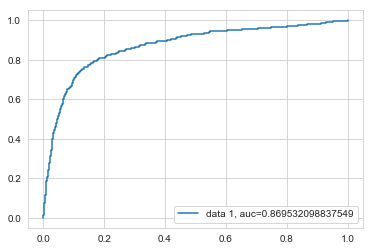

In [182]:
#AUC metrics
y_pred_proba = classifier.predict_proba(X_test_rfe)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [183]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89      8075
           1       0.20      0.81      0.32       477

    accuracy                           0.81      8552
   macro avg       0.59      0.81      0.61      8552
weighted avg       0.94      0.81      0.86      8552



In [184]:
list(zip(df_telecom.columns,rfe.support_,rfe.ranking_))

[('arpu_6', False, 28),
 ('arpu_7', False, 58),
 ('arpu_8', False, 4),
 ('onnet_mou_6', False, 48),
 ('onnet_mou_7', True, 1),
 ('onnet_mou_8', True, 1),
 ('offnet_mou_6', False, 70),
 ('offnet_mou_7', False, 32),
 ('offnet_mou_8', True, 1),
 ('roam_ic_mou_6', False, 112),
 ('roam_ic_mou_7', False, 80),
 ('roam_ic_mou_8', False, 81),
 ('roam_og_mou_6', False, 73),
 ('roam_og_mou_7', True, 1),
 ('roam_og_mou_8', False, 14),
 ('loc_og_t2t_mou_6', False, 72),
 ('loc_og_t2t_mou_7', False, 120),
 ('loc_og_t2t_mou_8', False, 17),
 ('loc_og_t2m_mou_6', False, 18),
 ('loc_og_t2m_mou_7', False, 37),
 ('loc_og_t2m_mou_8', False, 97),
 ('loc_og_t2f_mou_6', False, 38),
 ('loc_og_t2f_mou_7', False, 39),
 ('loc_og_t2f_mou_8', False, 25),
 ('loc_og_t2c_mou_6', False, 60),
 ('loc_og_t2c_mou_7', False, 62),
 ('loc_og_t2c_mou_8', False, 86),
 ('loc_og_mou_6', False, 98),
 ('loc_og_mou_7', False, 8),
 ('loc_og_mou_8', False, 7),
 ('std_og_t2t_mou_6', False, 108),
 ('std_og_t2t_mou_7', False, 85),
 ('std_

In [185]:
col = df_telecom.columns[rfe.support_]
col

Index(['onnet_mou_7', 'onnet_mou_8', 'offnet_mou_8', 'roam_og_mou_7',
       'std_og_t2m_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_7',
       'loc_ic_mou_8', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_mou_8',
       'total_ic_mou_6', 'total_ic_mou_8', 'spl_ic_mou_8',
       'last_day_rch_amt_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8',
       'aon', 'rech_days_left_8'],
      dtype='object')

### Building model using statsmodel, for the detailed statistics

In [186]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = df_telecom[col]

In [187]:
# Adding a constant variable 
import statsmodels.api as stm  
X_train_1 = stm.add_constant(X_train_rfe)

In [188]:
lm1 = stm.OLS(y,X_train_1).fit()   # Running the linear model

In [189]:
#Let's see the summary of our linear model
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     177.2
Date:                Mon, 19 Aug 2019   Prob (F-statistic):               0.00
Time:                        15:18:01   Log-Likelihood:                 3129.2
No. Observations:               28504   AIC:                            -6216.
Df Residuals:                   28483   BIC:                            -6043.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0845      0

### Summary: Feature reduction using RFE and Logistic regression

Observations
1. Got 80.0% accuracy 
2. Confusion matix shows that the model has drawback in predicting churn as high false positives.

## 4. Inferences

* Important features which contribute in prediction of a customer churn
    * nnet_mou_7
    * onnet_mou_8
    * offnet_mou_8
    * roam_og_mou_7
    * std_og_t2m_mou_7
    * loc_ic_t2t_mou_8
    * loc_ic_t2m_mou_7
    * loc_ic_mou_8
    * std_ic_t2t_mou_7
    * std_ic_t2t_mou_8
    * std_ic_mou_8
    * total_ic_mou_6
    * total_ic_mou_8
    * spl_ic_mou_8
    * last_day_rch_amt_8
    * monthly_2g_8
    * sachet_2g_8
    * monthly_3g_8
    * aon
    * rech_days_left_

* 7th month customers are inclined towards usage of calls local/STD/ISD
* 8th month customer continue to use calls but do show an inclination towards usage of mobile data 2G/3G searching and find different reacharge schemes/packs.


### Performance summary of ML algorithms

In [191]:
algorithm_summary = [["PCA", 0.81, 0.81,0.82,0.80],["Decision Tree", 0.66, 0.90, 0.84,0.78],["Random Forest",0.66,0.92,0.92,0.79],["Logistic regression",0.98,0.80,0.80,0.86]]
pd.DataFrame(algorithm_summary,columns=["Algorithm","Sensitivity","Specificity","Accurarcy","AUC"])

,Algorithm,Sensitivity,Specificity,Accurarcy,AUC
0,PCA,0.81,0.81,0.82,0.80
1,Decision Tree,0.66,0.90,0.84,0.78
2,Random Forest,0.66,0.92,0.92,0.79
3,Logistic regression,0.98,0.80,0.80,0.86


PCA helps us predict churn customers with an accuracy of 0.82.  
Logistic regression with RFE provides us predictors with an accuracy of 0.86.

## 5. Recommendation

* As call usage is extensive across the months Telecom company can think of some competitive pricing/schemes/packs for calls of local/STD/ISD/roaming
* By 7th to 8th month we do see an inclination towards mobile data where customer want to use more than just calling, competitive offers on 2G/3G would be a good add on. 
* There are segments of customers using only local calls with data, local & STD with data, STD and ISD calling alone, data alone.
* Ensemble offers calling and data would be attractive and beneficial to the customer and the Telecom company